# 1. Importación de Librerías

In [1]:
import pandas as pd
import json
import numpy as np
import athena_utils as au
import openia_script as OA

# 2. Definición de Consultas SQL

In [22]:
query_response_satisfaccion= '''

   SELECT DISTINCT 
    p.id as project_id,
    ce.name,
    cer.id, 
    cer.moodle_id, 
    cer.unique_id, 
    cer.activity_id, 
    cer.attempt_id, 
    cer.question_name,
    cer.question_id, 
    cer.question_attempt_id, 
    cer.answer
   
   FROM
    moodle_enrollment me

   LEFT JOIN moodle_course_evaluations ce ON (me.course_id = ce.course_id)
   LEFT JOIN moodle_course_evaluation_questions ceq ON (ce.unique_id = ceq.unique_id)
   LEFT JOIN moodle_course_evaluation_responses cer ON ((cer.unique_id = ceq.unique_id) AND (ceq.question_id = cer.question_id) AND (me.moodle_id = cer.moodle_id) AND (ce.type <> 'assign'))
   INNER JOIN room_room rr ON (rr.course_mdl_id = me.course_id)
   LEFT JOIN student_student ss ON (ss.user_mdl_id = me.moodle_id)
   LEFT JOIN room_room_students rrs ON ((rrs.student_id = ss.id) AND (rrs.room_id = rr.id))
   LEFT JOIN enrollment_enrolment ee ON (((ee.group_id = rr.group_id) OR (ee.room_id = rr.id)) AND (ee.student_id = ss.id) AND (ee.state <> 'cancel'))
   LEFT JOIN projects p ON (p.id = ee.b2b_project_id)

   WHERE 
   ce.tag IN ('cuestionario de satisfacción modular', 'cuestionario de satisfacción final') AND (ceq.tag IN ('detalle_programa', 'detalle_conocimiento_docente', 'detalle_contenido_programa', 'comentario_adicional_general', 'detalle_plataforma_campus', 'detalle_recomendacion_programa', 'detalle_socioocupacional', 'detalle_conocimiento_ocupacion', 'detalle_contenido_ocupacional', 'detalle_uso_laboral')) AND (me.role = 'student') AND (cer.attempt_time_finish IS NOT NULL) AND (ee.state <> 'cancel') AND (ee.state <> 'inactive') AND ((ceq.question_name <> 'label') OR (ceq.question_name IS NULL))
   
   order by p.id desc
   '''
query_sentiment_analysis= '''
SELECT
ceq.tag,
sa.* 

FROM
   sentiment_analysis sa
   left join moodle_course_evaluation_questions ceq on (sa.question_id = ceq.question_id and sa.unique_id = ceq.unique_id)

where 
   -- timecreated >= date('2025-01-01') and
   lower(sa.question_name) not like '%indica%'
   and lower(sa.question_name) not like '%qué tan fácil%';

'''

query_category_response= '''
SELECT
   *
FROM
   response_satisfaccion_category;
'''

# 3. Carga de Datos desde Athena

In [23]:
df_sentiment=au.run_athena_query(query_sentiment_analysis, 'sentiment')
df_sentiment = df_sentiment[df_sentiment['answer'].str.split().str.len() > 1]
#df_sentiment = df_sentiment[~df_sentiment['question_name'].str.contains('¿Qué tan', case=False, na=False)]

# Esto me sirve para cuando no existe df_categorias en una ejecucion manual
df_categorias= pd.DataFrame()

In [24]:
df_categorias=au.run_athena_query(query_category_response, 'category_response')

In [25]:
columnas_comparar = ['moodle_id', 'unique_id', 'activity_id', 'attempt_id', 'question_id', 'answer']  # Cambia por las columnas que realmente definen la unicidad

if df_categorias.empty:
    df_inprocess = df_sentiment.copy()
else:
    df_categorias = df_categorias[df_categorias['answer'].notnull() & (df_categorias['answer'] != '')] # Elimino respuestas que estan con caracter vacio
    df_inprocess = df_sentiment.merge(
        df_categorias[columnas_comparar],
        on=columnas_comparar,
        how='left',
        indicator=True
    )
    df_inprocess = df_inprocess[df_inprocess['_merge'] == 'left_only']
    df_inprocess = df_inprocess.drop(columns=['_merge'])

# 4. Procesamiento y Categorización con OpenAI

## 4.1. Funciones

In [26]:
# A las categorias de comentario positivo y negativo les concateno una columna de tag
def agregar_tag_a_categoria(row):
    """
    Agrega un tag a las categorías de comentarios generales basándose en la presencia de palabras clave
    en el campo 'tag'.
    """
    categoria = row['categoria']
    tag_raw = row.get('tag', None)
    question_raw = row.get('question_name', '')

    tag = str(tag_raw).strip().lower() if tag_raw is not None else ''
    question = str(question_raw).strip().lower()

    # Si 'tag' está vacío/NaN/None, usar 'question'
    texto = tag if tag not in ('', 'nan', 'none') else question

    if categoria in ['Comentarios positivos generales', 'Comentarios negativos generales']:
        if 'contenido' in texto:
            categoria += ' (contenido)'
        elif 'docente' in texto:
            categoria += ' (docente)'
        elif 'programa' in texto:
            categoria += ' (programa)'
        elif 'campus' in texto:
            categoria += ' (campus)'

    return categoria


## 4.2 Proceso

In [ ]:
# Para propositos de prueba, se utiliza un subconjunto del DataFrame.
# Descomentar la siguiente linea para trabajar con el DataFrame completo.
#df_inprocess=df_inprocess.sample(n=100, random_state=123) # es para no trabajar sobre todo el dataframe [100 filas aleatorias]

In [27]:
# Para estimar la cantidad de lotes que se van a procesar del dataframe
batches=OA.split_batches_fast(df_inprocess)
for i, batch in enumerate(batches, 1):
    tokens = OA.count_tokens(OA.PROMPT_CATEGORIZACION) + OA.count_tokens("Por favor, categoriza el siguiente lote de respuestas: ") + OA.count_tokens(json.dumps(batch, ensure_ascii=False))
    print(f"Lote {i}: {len(batch)} respuestas, ~{tokens} tokens")

Lote 1: 37 respuestas, ~3933 tokens
Lote 2: 36 respuestas, ~3914 tokens
Lote 3: 33 respuestas, ~3929 tokens
Lote 4: 29 respuestas, ~3916 tokens
Lote 5: 30 respuestas, ~3928 tokens
Lote 6: 32 respuestas, ~3947 tokens
Lote 7: 33 respuestas, ~3910 tokens
Lote 8: 31 respuestas, ~3928 tokens
Lote 9: 29 respuestas, ~3931 tokens
Lote 10: 33 respuestas, ~3945 tokens
Lote 11: 31 respuestas, ~3924 tokens
Lote 12: 31 respuestas, ~3941 tokens
Lote 13: 32 respuestas, ~3933 tokens
Lote 14: 30 respuestas, ~3910 tokens
Lote 15: 32 respuestas, ~3894 tokens
Lote 16: 34 respuestas, ~3912 tokens
Lote 17: 32 respuestas, ~3909 tokens
Lote 18: 33 respuestas, ~3904 tokens
Lote 19: 32 respuestas, ~3903 tokens
Lote 20: 32 respuestas, ~3904 tokens
Lote 21: 32 respuestas, ~3946 tokens
Lote 22: 33 respuestas, ~3924 tokens
Lote 23: 37 respuestas, ~3938 tokens
Lote 24: 34 respuestas, ~3931 tokens
Lote 25: 33 respuestas, ~3926 tokens
Lote 26: 33 respuestas, ~3892 tokens
Lote 27: 22 respuestas, ~3934 tokens
Lote 28: 3

In [28]:
# Agrega la columna 'categoria' al dataframe analizada por llm
df_inprocess=OA.categorizar_dataframe(df=df_inprocess, parallel_calls=8) # Aca se aplican las categorias

# quito del dataframe las cateogias que son "Sin categoria"
print(f"Respuestas sin categorias: {len(df_inprocess[df_inprocess['categoria'] == 'Sin categoría'])}")
df_inprocess = df_inprocess[df_inprocess['categoria'] != 'Sin categoría']

Respuestas sin categorias: 0


In [29]:
mapeo_categorias = {
    "Contenido claro y fácil de entender": ["Contenido", "Positivo"],
    "Contenido útil y aplicable a mi carrera": ["Contenido", "Positivo"],
    "Contenido entretenido y motivador": ["Contenido", "Positivo"],
    "Contenido confuso o difícil de seguir": ["Contenido", "Negativo"],
    "Contenido aburrido o monótono": ["Contenido", "Negativo"],
    "Contenido sin relevancia para mis objetivos": ["Contenido", "Negativo"],

    "Buen nivel de explicación del docente": ["Docente", "Positivo"],
    "Docente experto y con dominio del tema": ["Docente", "Positivo"],
    "Docente amable y paciente al resolver dudas": ["Docente", "Positivo"],
    "Docente con método poco dinámico o poco claro": ["Docente", "Negativo"],
    "Docente que demuestra falta de conocimiento": ["Docente", "Negativo"],
    "Docente poco dispuesto a ayudar": ["Docente", "Negativo"],
    "Problemas técnicos": ["Programa", "Negativo"],

    "Plataforma intuitiva y rica en recursos": ["Plataforma", "Positivo"],
    "Plataforma confusa o con fallos técnicos": ["Plataforma", "Negativo"],

    "Proyecto motivador": ["Programa", "Positivo"],
    "Proyecto desmotivador": ["Programa", "Negativo"],
    "Sugerencias y propuestas de mejora": ["Programa", "Positivo"],
    "Comentarios positivos generales": ["Programa", "Positivo"],
    "Comentarios negativos generales": ["Programa", "Negativo"],

    "Otro": ["Otro", "Neutro"],
    "Comentarios positivos generales (docente)": ["Docente", "Positivo"],
    "Comentarios positivos generales (programa)": ["Programa", "Positivo"],
    "Comentarios positivos generales (contenido)": ["Contenido", "Positivo"],
    "Comentarios positivos generales (campus)": ["Plataforma", "Positivo"],

    "Comentarios negativos generales (docente)": ["Docente", "Negativo"],
    "Comentarios negativos generales (programa)": ["Programa", "Negativo"],
    "Comentarios negativos generales (contenido)": ["Contenido", "Negativo"],
    "Comentarios negativos generales (campus)": ["Plataforma", "Negativo"]
}


In [30]:
# Aca se desglozo para que quede una categoria por fila,
# en caso de respuestas que tengan asiganadas mas de una 

df_inprocess['categoria'] = df_inprocess['categoria'].apply(lambda x: x if isinstance(x, list) else [x])

df_explode=df_inprocess.explode('categoria')
df_explode=df_explode.explode('categoria')

# Mapeo las categorias
df_explode['categoria_tipo'] = df_explode['categoria'].map(lambda x: mapeo_categorias.get(x, [None, None])[0])
df_explode['categoria_sentimiento'] = df_explode['categoria'].map(lambda x: mapeo_categorias.get(x, [None, None])[1])

df_explode['categoria']=df_explode['categoria'].str.split('_').str[0]

# Elimino las que suponen un error
df_explode = df_explode[df_explode['categoria'] != 'Sin categoría']
df_explode = df_explode[df_explode['categoria'].notna() & df_explode['categoria'].notnull()]

# A las categorias de comentario positivo y negativo les concateno una columna de tag
df_explode['categoria'] = df_explode.apply(agregar_tag_a_categoria, axis=1)

# Re-mapeo las categorias
df_explode['categoria_tipo'] = df_explode['categoria'].map(lambda x: mapeo_categorias.get(x, [None, None])[0])
df_explode['categoria_sentimiento'] = df_explode['categoria'].map(lambda x: mapeo_categorias.get(x, [None, None])[1])

contador=len(df_explode)
# Borrar categorias que no existan dentro del mapeo_categorias
df_explode = df_explode[df_explode['categoria'].isin(mapeo_categorias.keys())]
print(contador-len(df_explode), " categorias eliminadas que no existen en el mapeo")


12  categorias eliminadas que no existen en el mapeo


In [31]:
if not df_categorias.empty:
    df_explode=pd.concat([df_categorias, df_explode], ignore_index=True)

# 5. Análisis de Costos de OpenAI

In [32]:
# Costo de ejecucion
OA.guardar_metricas()

Solo el total de la ejecución guardado en 'metricas_uso_openai.csv'
Modelo: gpt-4o-mini
Tokens enviados: 219697
Tokens recibidos: 45700


# 6. Fusión y Análisis de Datos

In [33]:
pd.set_option('display.max_colwidth', None) # Me amplia la ventanas de celdas


In [1]:
df_explode[['unique_id', 'question_name', 'answer','categoria_tipo', 'categoria_sentimiento', 'categoria', 'sentiment_analysis']].sample(5)

NameError: name 'df_explode' is not defined

In [35]:
df_explode.columns

Index(['id', 'moodle_id', 'unique_id', 'activity_id', 'type', 'activity_name',
       'timecreated', 'timeclose', 'attempt_id', 'attempt_state',
       'attempt_time_finish', 'question_id', 'question_name', 'answer',
       'right_answer', 'max_possible_question_grade',
       'max_possible_total_grade', 'calification_question',
       'calification_total_attempt', 'sentiment_analysis', 'sentiment_score',
       'categoria', 'categoria_tipo', 'categoria_sentimiento', 'tag'],
      dtype='object')

In [36]:
# Sube el json a s3
au.export_dataframe_to_s3_json(df_explode, 'moodle_category_responses')

✅ JSON exportado correctamente a s3://raw-data-lake-virginia/python/category_analysis/moodle_category_responses.json


# 7. Análisis de Categorías Generadas

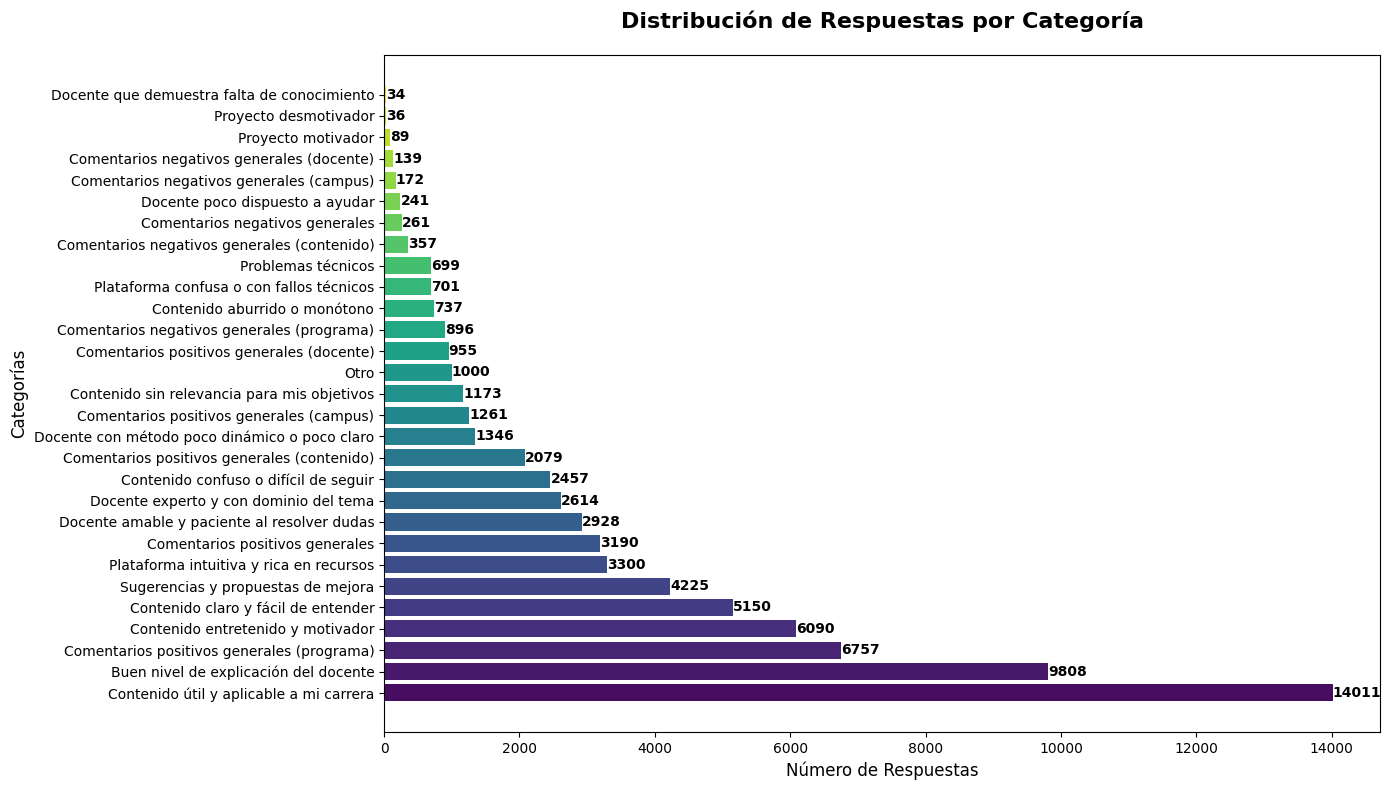

Resumen estadístico por categoría:
Total de respuestas categorizadas: 72706
Número de categorías únicas: 29
Top 5 categorías más frecuentes:
--------------------------------------------------
categoria
Contenido útil y aplicable a mi carrera       14011
Buen nivel de explicación del docente          9808
Comentarios positivos generales (programa)     6757
Contenido entretenido y motivador              6090
Contenido claro y fácil de entender            5150
Name: count, dtype: int64


In [37]:
# Gráfico de columnas por categoría
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo del gráfico
plt.style.use('default')
sns.set_palette("husl")

# Contar las respuestas por categoría
categoria_counts = df_explode['categoria'].value_counts()

# Crear el gráfico de barras horizontales
plt.figure(figsize=(14, 8)) 
bars = plt.barh(range(len(categoria_counts)), categoria_counts.values,
                color=sns.color_palette("viridis", len(categoria_counts)))

# Configurar el eje Y con los nombres de las categorías
plt.yticks(range(len(categoria_counts)), categoria_counts.index)

# Configurar títulos y etiquetas
plt.title('Distribución de Respuestas por Categoría', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Número de Respuestas', fontsize=12)
plt.ylabel('Categorías', fontsize=12)

# Agregar valores al final de cada barra
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center', fontweight='bold')

# Ajustar el layout para que no se corten las etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# También mostrar un resumen estadístico
print("Resumen estadístico por categoría:")
print("=" * 50)
print(f"Total de respuestas categorizadas: {len(df_explode)}")
print(f"Número de categorías únicas: {len(categoria_counts)}")
print("Top 5 categorías más frecuentes:")
print("-" * 50)
print(categoria_counts.head())
